In [83]:
import pandas as pd
import seaborn as sns
import re, string
import matplotlib.pyplot as plt
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/lzj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [84]:
train_data = pd.read_csv("/home/lzj/下载/nlp/train.csv")
test_data = pd.read_csv("/home/lzj/下载/nlp/test.csv")

In [85]:
#训练数据有7613个观察值和5个特征，包括目标(我们想要预测的标签)。
print("train_data shape:", train_data.shape) 
train_data.head()

train_data shape: (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [86]:
#测试数据有3263个观察值和四个特征
print("test_data shape:",  test_data.shape)
test_data.head()

test_data shape: (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [87]:
# EDA(探索性数据分析)
#先看缺失值
train_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [88]:
test_data.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [89]:
# 看看训练数据集中, target 特征下样本各类统计情况
train_data["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

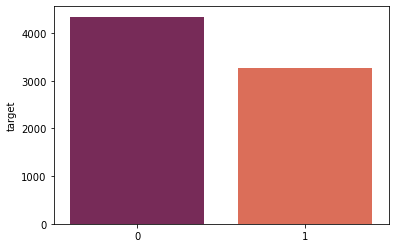

In [90]:
# 类别样本分布图
sns.barplot(train_data['target'].value_counts().index,train_data['target'].value_counts(),palette='rocket')

In [91]:
#现在来看看 灾难推特 和 非灾难推特 都是什么样子的
disaster_tweets = train_data[train_data['target']==1]['text']
disaster_tweets.values[1]

'Forest fire near La Ronge Sask. Canada'

In [92]:
non_disaster_tweets = train_data[train_data['target']==0]['text']
non_disaster_tweets.values[1]

'I love fruits'

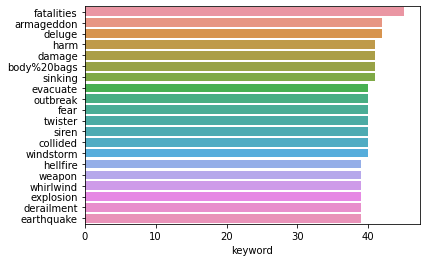

In [93]:
# 特征 keyword 分析， 看看前15的高频词分布
sns.barplot(y=train_data['keyword'].value_counts()[:20].index,x=train_data['keyword'].value_counts()[:20],
            orient='h')

In [94]:
# 新在来看直接包含 词 disaster 的twitter数量类别分布
train_data.loc[train_data['text'].str.contains('disaster', na=False, case=False)].target.value_counts()

1    102
0     40
Name: target, dtype: int64

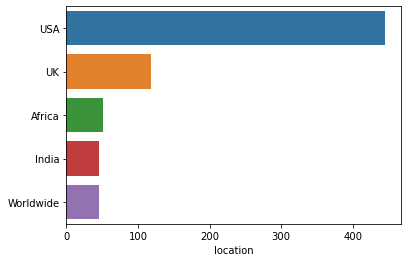

In [95]:
# 特征 location 分析, 
# Replacing the ambigious locations name with Standard names
train_data['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

sns.barplot(y=train_data['location'].value_counts()[:5].index,x=train_data['location'].value_counts()[:5],
            orient='h')

In [96]:
# 特征 text 处理， 这是 文本能否正确分类的关键
# 常见的关于文本数据预处理可以包括， 大小写变换，标点符号移除， 数值删除， 分词， 停词移除，其余的比如词干提取， 词形还原等；
# 下面我们一一实验

In [97]:
train_data['text'][:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [98]:
#使文本小写，删除方括号中的文本，删除链接，删除标点符号, 并删除含有数字的单词

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


In [99]:
# 对测试和训练数据集应用上面定义的函数
train_data['text'] = train_data['text'].apply(lambda x: clean_text(x))
test_data['text'] = test_data['text'].apply(lambda x: clean_text(x))


# 观察 清理后的 特征 text
train_data["text"][:5]

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

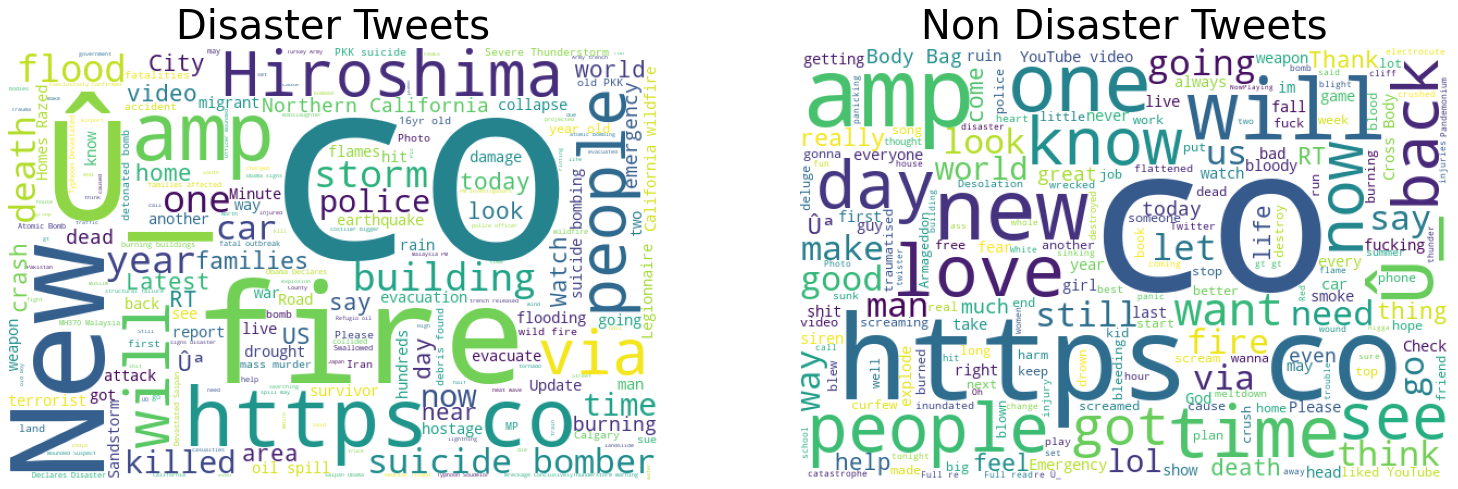

In [100]:
from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

In [101]:
# 现在开始分词， 把一个输入语句每个词语分开， 构成词列表

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train_data['text'] = train_data['text'].apply(lambda x: tokenizer.tokenize(x))
test_data['text'] = test_data['text'].apply(lambda x: tokenizer.tokenize(x))
train_data['text'].head()
test_data["text"].head()

0            [just, happened, a, terrible, car, crash]
1    [heard, about, earthquake, is, different, citi...
2    [there, is, a, forest, fire, at, spot, pond, g...
3           [apocalypse, lighting, spokane, wildfires]
4    [typhoon, soudelor, kills, in, china, and, tai...
Name: text, dtype: object

In [102]:
# 停词移除, 英语中比如 a, an, the, are诸如此类的词语称为stopwords，它们通常包含的
#信息有限， 且数量众多
from nltk.corpus import stopwords
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words


train_data['text'] = train_data['text'].apply(lambda x : remove_stopwords(x))
test_data['text'] = test_data['text'].apply(lambda x : remove_stopwords(x))
train_data.head()



,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [331]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,"[happened, terrible, car, crash]"
1,2,NaN,NaN,"[heard, earthquake, different, cities, stay, s..."
2,3,NaN,NaN,"[forest, fire, spot, pond, geese, fleeing, acr..."
3,9,NaN,NaN,"[apocalypse, lighting, spokane, wildfires]"
4,11,NaN,NaN,"[typhoon, soudelor, kills, china, taiwan]"


In [333]:
import pandas as pd

combine_data = pd.concat([train_data, test_data], axis=0)
combine_data.shape

(10876, 5)

In [338]:
combine_data

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1.0
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1.0
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1.0
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1.0
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1.0
...,...,...,...,...,...
3258,10861,NaN,NaN,"[earthquake, safety, los, angeles, ûò, safety,...",NaN
3259,10865,NaN,NaN,"[storm, ri, worse, last, hurricane, hardest, h...",NaN
3260,10868,NaN,NaN,"[green, line, derailment, chicago]",NaN
3261,10874,NaN,NaN,"[meg, issues, hazardous, weather, outlook, hwo]",NaN


In [340]:
# 转换成 文本格式
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

combine_data["text"] = combine_data["text"].apply(lambda x: combine_text(x))




,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1.0
1,4,NaN,NaN,forest fire near la ronge sask canada,1.0
2,5,NaN,NaN,residents asked shelter place notified officer...,1.0
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1.0
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1.0
...,...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles ûò safety fasten...,NaN
3259,10865,NaN,NaN,storm ri worse last hurricane hardest hit yard...,NaN
3260,10868,NaN,NaN,green line derailment chicago,NaN
3261,10874,NaN,NaN,meg issues hazardous weather outlook hwo,NaN


In [341]:
# 词语向量化，以适合作为机器学习模型的输入
# 常见的词向量化模型， 比如 bag of words, word2vec, glove, fast_text等；
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()
combine_vectors = count_vectorizer.fit_transform(combine_data['text'])
test_vectors = count_vectorizer.transform(test_data["text"].apply(lambda x: combine_text(x)))
train_vectors = count_vectorizer.transform(train_data["text"].apply(lambda x: combine_text(x)))

 
train_vectors[:2].todense()


matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [342]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train_data['text'].apply(lambda x: combine_text(x)))
test_tfidf = tfidf.transform(test_data["text"].apply(lambda x: combine_text(x)))

train_tfidf[:2].todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [343]:
# 构建机器学习模型
# 这里我们用 逻辑斯蒂回归， 朴素贝叶斯, xgboost算法，利用交叉验证的方法多次拟合
# 基于countvectorzier构建的此向量
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
clf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf, train_vectors, train_data["target"], cv=5, scoring="f1")
scores.mean()


0.5834476966398702

In [344]:
# 基于TDIDF 构建的此向量

clf_tfidf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, train_data["target"], cv=5, scoring="f1")
scores.mean()

0.5451346913743611

In [345]:
# 朴素贝叶斯分类器, 基于contervectorzier
from sklearn.naive_bayes import MultinomialNB
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors, train_data["target"], cv=5, scoring="f1")
scores.mean()

0.6587143478450784

In [346]:
# 朴素贝叶斯, 基于TFIDF
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train_data["target"], cv=5, scoring="f1")
scores.mean()


0.6187711183101462

In [347]:
# xgboost model 
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb, train_vectors, train_data["target"], cv=5, scoring="f1")
scores.mean()

0.43958295564631894

In [348]:
clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, train_data["target"], cv=5, scoring="f1")
scores.mean()

0.4391881943064654

In [350]:
#由以上结果，选择 朴素贝叶斯模型, TDIDF表征词向量

clf = clf_NB.fit(train_vectors, train_data["target"])

In [353]:
clf.predict(test_vectors)

array([1, 1, 1, ..., 1, 1, 1])

In [355]:
# 定义文件提交函数

def submission(submission_file_path,model,test_vectors):
    sample_submission = pd.read_csv(submission_file_path)
    sample_submission["target"] = model.predict(test_vectors)
    sample_submission.to_csv("submission.csv", index=False)


submission_file_path = "/home/lzj/下载/nlp/sample_submission.csv"
model = clf
test_vectors = test_vectors
submission(submission_file_path, model, test_vectors)